## Loading of Miller ECoG data of the joystick track task

includes some visualizations

In [2]:
#@title Data retrieval
import os, requests

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 4.8 MB/s eta 0:00:00


In [9]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]

print(dat.keys())

dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 4 sessions from 4 subjects, and was used in these papers:

- Schalk, G., et al. "Decoding two-dimensional movement trajectories using electrocorticographic signals in humans." Journal of Neural Engineering 4.3 (2007): 264. doi: [10.1088/1741-2560/4/3/012](https://doi.org/10.1088/1741-2560/4/3/012)

- Schalk, Gerwin, et al. "Two-dimensional movement control using electrocorticographic signals in humans." Journal of Neural Engineering 5.1 (2008): 75. doi: [10.1088/1741-2560/5/1/008](https://doi.org/10.1088/1741-2560/5/1/008)

<br>

From the dataset readme:

*During the study, each patient was in a semi-recumbent position in a hospital bed about 1 m from a computer monitor. The patient used a joystick to maneuver a white cursor track a green target moving counter-clockwise in a circle of diameter 85% of monitor height ~1m away. The hand used to control the joystick was contralateral to the implanted electrode array.*

<br>

We also know that subject 0 was implanted in the left temporal lobe, while subject 2 was implanted in the right frontal lobe.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size.

Variables are:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['targetX']`: position of the target on the screen
* `dat['targetY']`: position of the target on the screen
* `dat['cursorX']`: X position of the cursor controlled by the joystick
* `dat['cursorY']`: X position of the cursor controlled by the joystick
* `dat['locs`]: three-dimensional coordinates of the electrodes

In [5]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [47]:
# compute correlations between voltage data and X/Y position of cursor
from scipy import signal
dat = alldat[0][3]

V = dat['V'].astype('float32')

nt, nchan = V.shape

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()

cx = np.zeros(nchan, )
cy = np.zeros(nchan, )
for j in range(nchan):
  cx[j] = np.corrcoef(V[:, j], targetX)[0, 1]
  cy[j] = np.corrcoef(V[:, j], targetY)[0, 1]

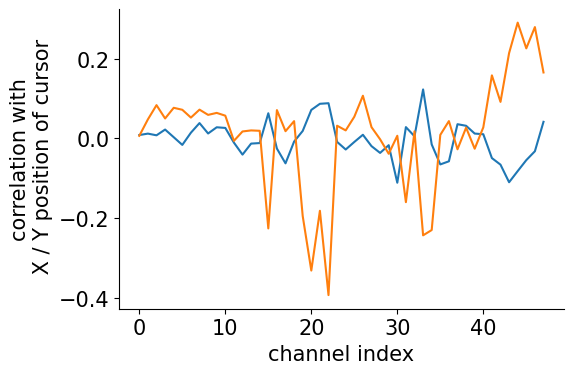

In [24]:
plt.subplot(1, 4, 1)
plt.plot(cx)
plt.plot(cy)
plt.ylabel('correlation with\n X / Y position of cursor')
plt.xlabel('channel index')
plt.show()

In [8]:
# this one needs a lot more plots!
# for some reason, I only see meaningful correlations in subjects 2 and 3,
# but it's possible that there is spectral information that is more useful in those subjects

In [11]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.4 MB/s eta 0:00:00


In [27]:
V.shape

(259920, 48)

In [30]:
import pandas as pd

summary_stats = pd.DataFrame(dat['V']).describe()
summary_stats

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
count,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,...,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000,259920.000000
mean,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,-5.937500,-6.160156,-6.226562,-6.308594,-6.382812,-6.152344,-7.460938,-6.144531,-6.136719,-7.902344,...,-5.980469,-8.320312,-5.390625,-6.378906,-10.968750,-3.873047,-4.445312,-7.386719,-6.496094,-12.726562
25%,-0.321838,-0.382812,-0.395813,-0.310059,-0.545532,-0.577759,-0.427002,-0.434570,-0.531738,-0.582031,...,-0.641113,-0.648926,-0.663086,-0.658203,-0.623047,-0.658203,-0.652832,-0.653809,-0.643555,-0.611328
50%,0.056900,0.083252,0.090027,0.101807,0.049194,0.034317,0.087280,0.080261,0.060272,0.022514,...,0.006802,-0.001396,-0.006752,-0.008587,-0.012436,-0.027161,-0.019836,-0.027565,-0.020119,-0.034073
75%,0.464111,0.533203,0.548340,0.520508,0.618652,0.616211,0.577148,0.574219,0.635254,0.627930,...,0.640137,0.646484,0.641113,0.648438,0.607910,0.633789,0.635742,0.626465,0.621094,0.576660
max,4.562500,4.175781,3.833984,3.886719,4.117188,4.222656,4.265625,4.207031,4.691406,4.949219,...,4.804688,6.035156,5.179688,5.246094,6.996094,5.253906,4.695312,5.175781,4.765625,5.902344


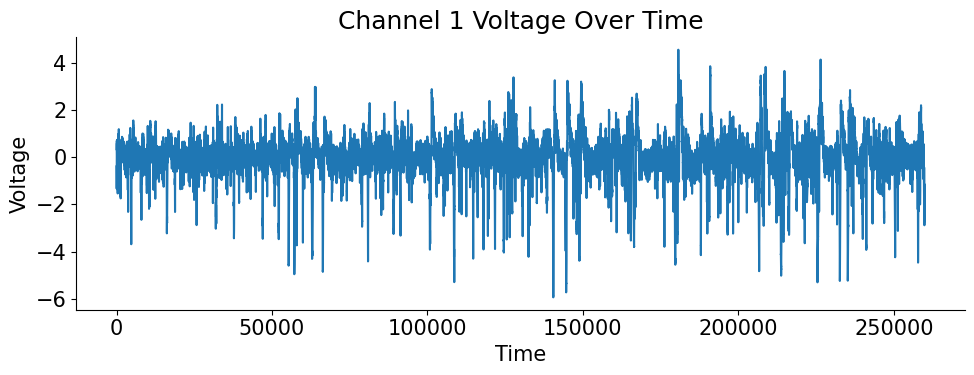

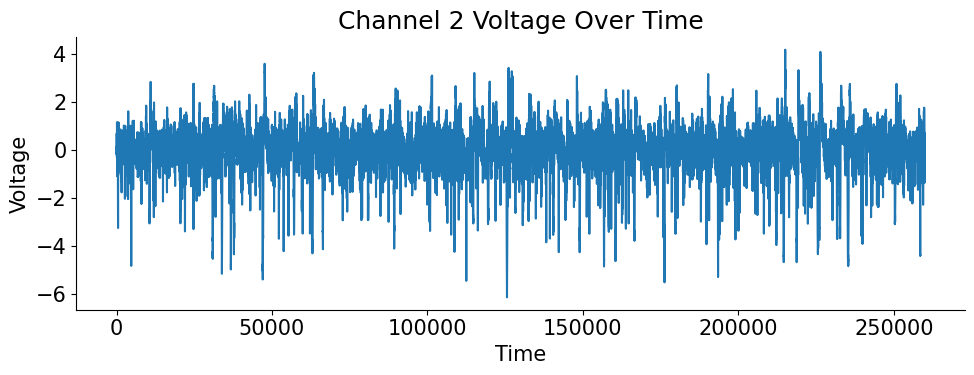

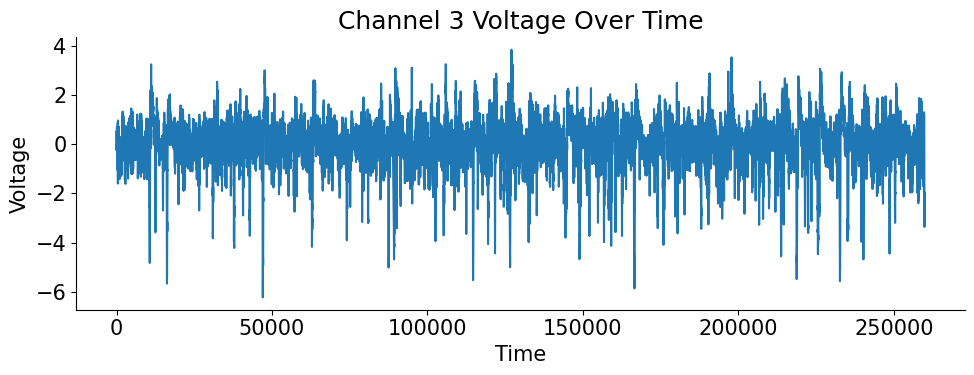

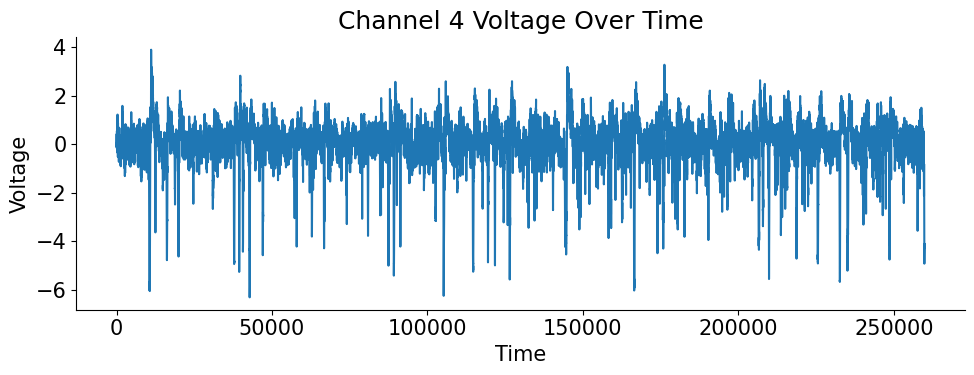

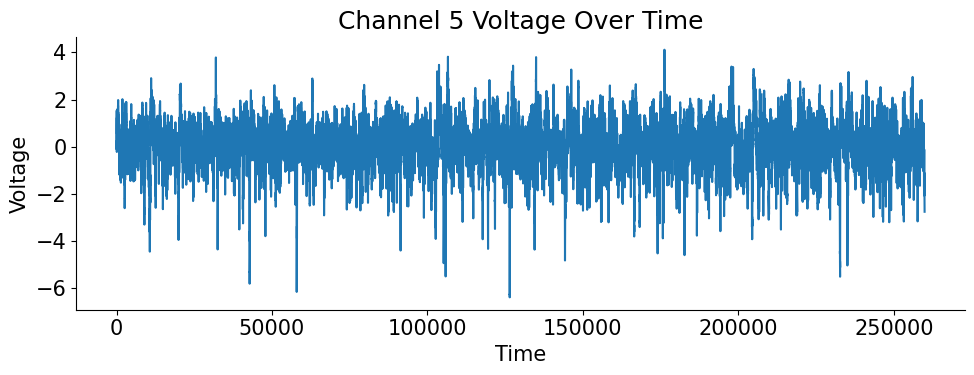

In [31]:
import matplotlib.pyplot as plt

# Plotting the first 5 channels as an example
for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.plot(dat['V'][:, i])
    plt.title(f'Channel {i+1} Voltage Over Time')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.show()

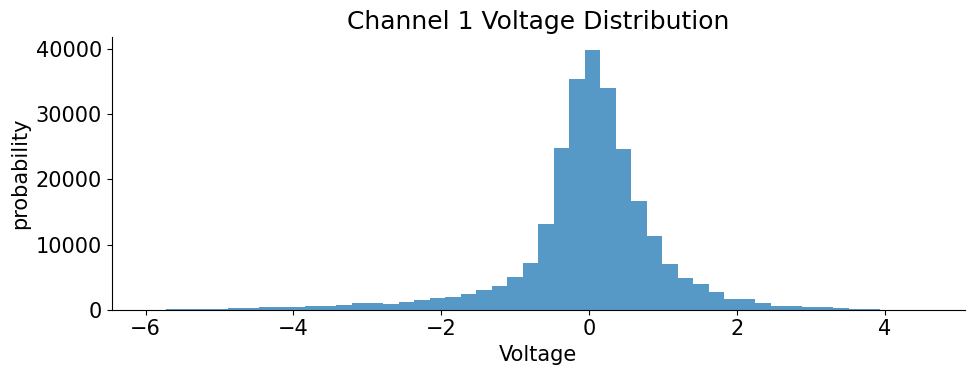

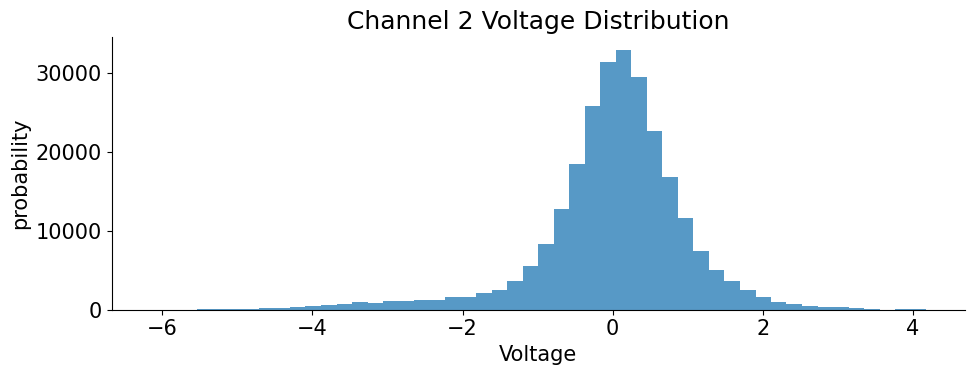

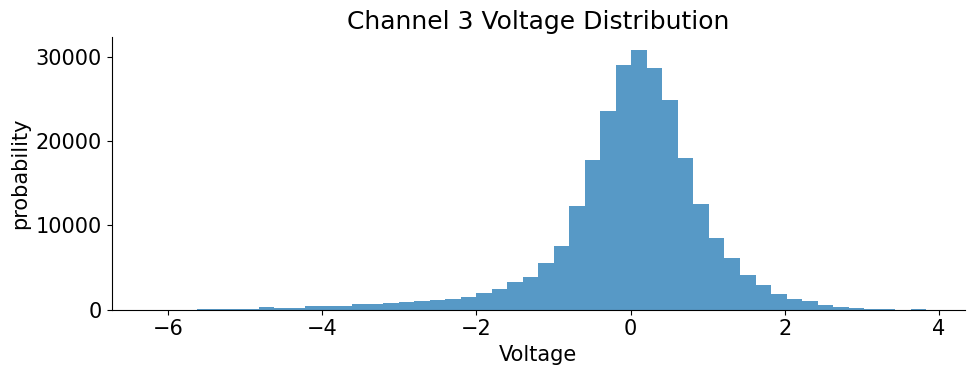

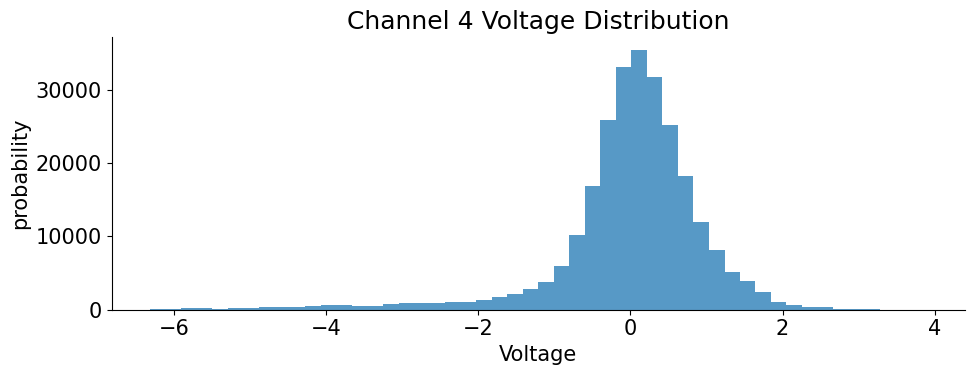

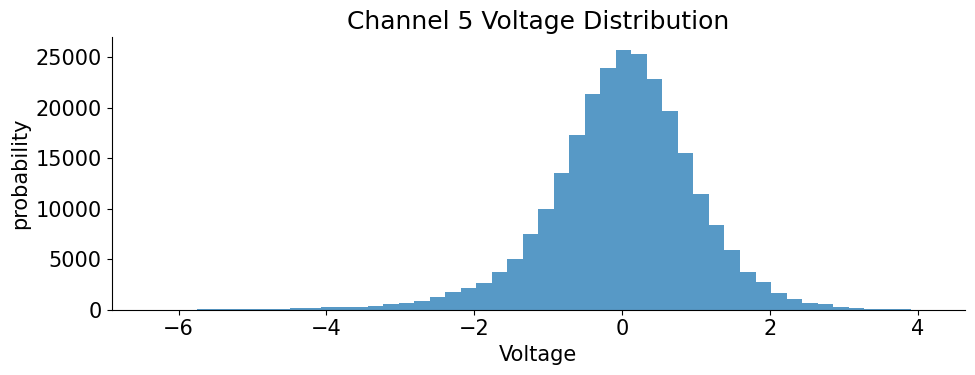

In [33]:
# Plotting histograms for the first 5 channels as an example
for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.hist(dat['V'][:, i], bins=50, alpha=0.75)
    plt.title(f'Channel {i+1} Voltage Distribution')
    plt.xlabel('Voltage')
    plt.ylabel('probability')
    plt.show()

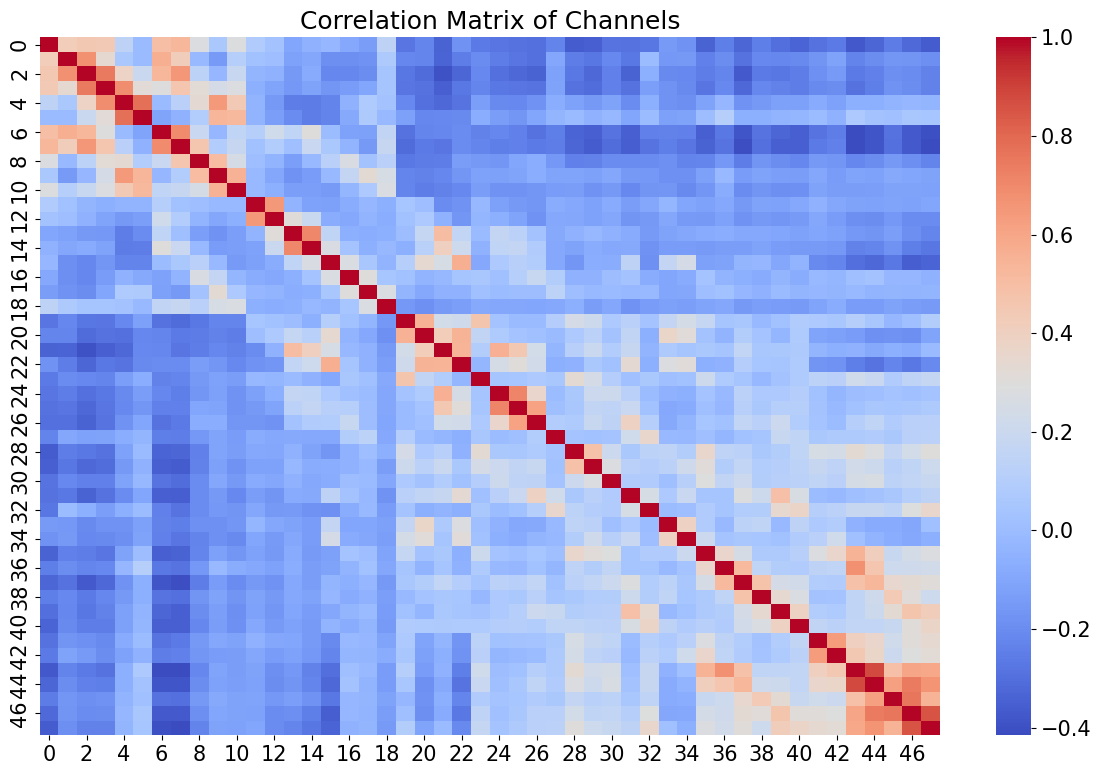

In [46]:
correlation_matrix = pd.DataFrame(dat['V']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Channels')
plt.show()

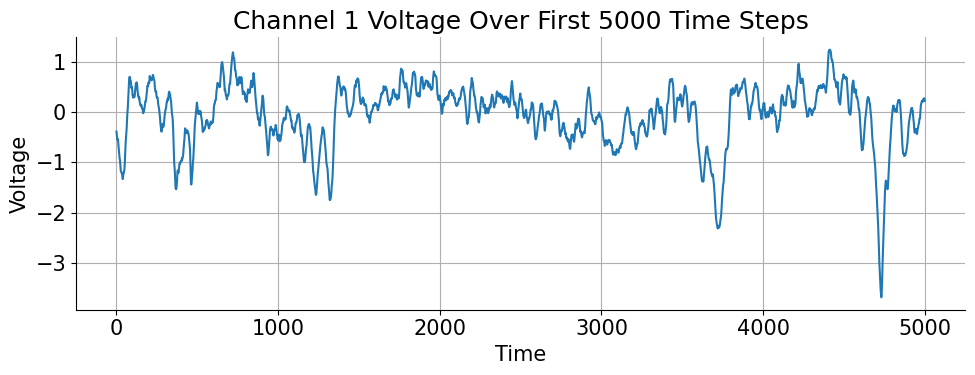

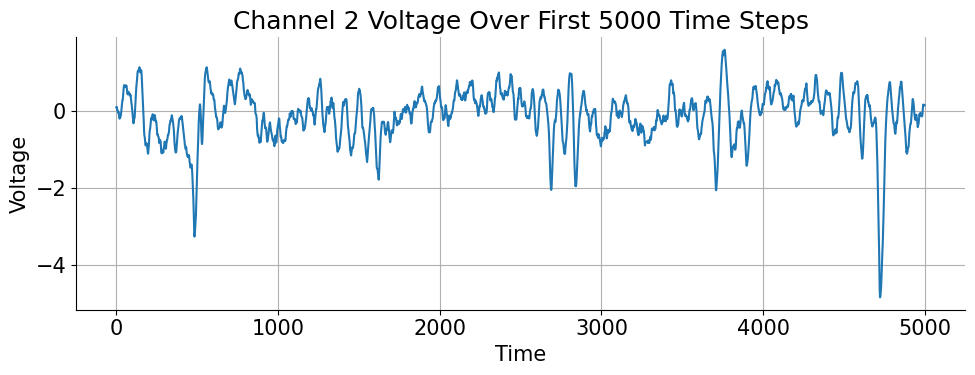

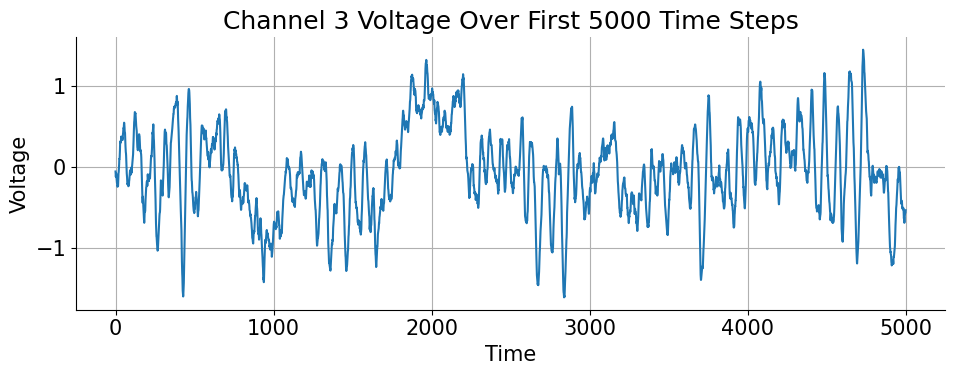

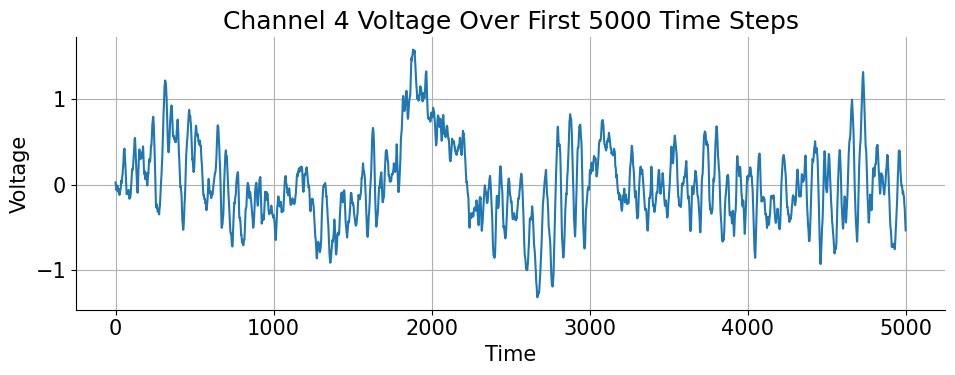

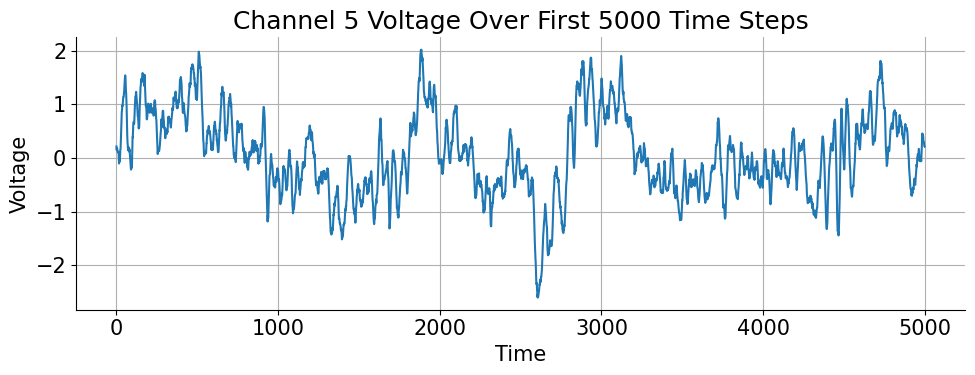

In [45]:
for i in range(5):
    plt.figure(figsize=(10, 4))
    plt.plot(dat['V'][:5000, i])
    plt.title(f'Channel {i+1} Voltage Over First 5000 Time Steps')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.grid(True)
    plt.show()